In [ ]:
# Import files from google drive
from google.colab import files
uploaded = files.upload()

In [ ]:
# Unzip dataset
!unzip Dataset

Archive:  Dataset.zip
replace Dataset/mHealth_subject1.log? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Import relevant libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import _pickle as cPickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle
import sys
import os

files=os.listdir("Dataset/")
folder="Dataset/"

In [ ]:
features=[]
labels=[]

#loop over all files to get features and labels
with tqdm(total=len(files)) as pbar:
    for f1 in files:
        name=folder+f1
        f = open(name, 'r')
        x=f.readline()
        while(x):
            x=x.split()
            labels.append(int(x[-1]))
            del x[-1]
            sublist=[]
            for val in x:
                sublist.append(val)
            features.append(np.array(sublist))
            x=f.readline()
        pbar.update(1)

# Convert to an array
features=np.array(features)
labels=np.array(labels)

# Print shape of features and labels
print(features.shape)
print(labels.shape)

# Print unique labels
print(np.unique(labels))

#saving for future use
with open("features", 'wb') as fp:
    pickle.dump(features, fp)

with open("labels", 'wb') as fp:
    pickle.dump(labels, fp)

100%|██████████| 10/10 [00:13<00:00,  1.26s/it]


(1215745, 23)
(1215745,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from matplotlib import style
import string
from collections import Counter
import sys
import pickle
import glob
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [ ]:
# getting data
with open('features', 'rb') as fp:
    X=pickle.load(fp)

with open('labels', 'rb') as fp:
    y=pickle.load(fp)

In [ ]:
# One Hot Encode
oh=OneHotEncoder()
y=oh.fit_transform(np.reshape(y,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Train / Test 
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42, shuffle=True)

X_train=np.expand_dims(X_train,axis=2)
X_test=np.expand_dims(X_test,axis=2)

Train on 972596 samples, validate on 243149 samples
Epoch 1/4
972596/972596 [==============================] - 3236s 3ms/step - loss: 0.8099 - acc: 0.7383 - val_loss: 0.6747 - val_acc: 0.7487
Epoch 2/4
972596/972596 [==============================] - 3242s 3ms/step - loss: 0.6522 - acc: 0.7553 - val_loss: 0.6024 - val_acc: 0.7686
Epoch 3/4
972596/972596 [==============================] - 3233s 3ms/step - loss: 0.6087 - acc: 0.7647 - val_loss: 0.5727 - val_acc: 0.7765
Epoch 4/4
972596/972596 [==============================] - 3217s 3ms/step - loss: 0.5868 - acc: 0.7698 - val_loss: 0.5580 - val_acc: 0.7775
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


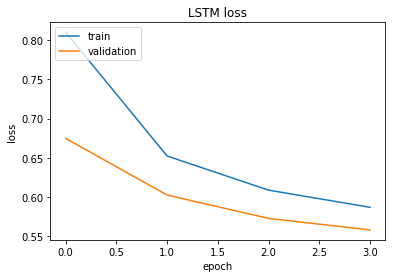

In [ ]:
# LSTM network
input = Input(shape=(23,1))

cnn=LSTM(8,return_sequences=True)(input)
cnn=LSTM(16)(cnn)

d=Dense(128, activation='relu')(cnn)
d=Dropout(0.4)(d)

d=Dense(256, activation='relu')(d)
d=Dropout(0.4)(d)

d=Dense(512, activation='relu')(d)

# Dense layer that has a softmax activation function
output = Dense(13, activation='softmax')(d)

model = Model(inputs=input, outputs=output)

# defining learning rate and optimizer
adam=Adam(lr=0.0001)

# Compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train,y_train,batch_size=32, epochs=4,validation_data=(X_test,y_test))

model.save('lstm.h5')

with open("OH", 'wb') as fp:
    pickle.dump(oh, fp)

# plotting stats of model
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("LSTM-loss.png")

with open("X_test-LSTM", 'wb') as fp:
    pickle.dump(X_test, fp)

with open("y_test_LSTM", 'wb') as fp:
    pickle.dump(y_test, fp)

In [ ]:
# print models layers
print(model.layers)

[<keras.engine.input_layer.InputLayer object at 0x7f63f51ae518>, <keras.layers.recurrent.LSTM object at 0x7f63f51ae4e0>, <keras.layers.recurrent.LSTM object at 0x7f63f51ae588>, <keras.layers.core.Dense object at 0x7f63f51aea20>, <keras.layers.core.Dropout object at 0x7f63f5045128>, <keras.layers.core.Dense object at 0x7f63d18165c0>, <keras.layers.core.Dropout object at 0x7f63d1816ef0>, <keras.layers.core.Dense object at 0x7f63d172ea20>, <keras.layers.core.Dense object at 0x7f63d1715f98>]


In [ ]:
# print models input layer
print(model.input)

Tensor("input_2:0", shape=(?, 23, 1), dtype=float32)


In [ ]:
# print models output layer
print(model.outputs)

[<tf.Tensor 'dense_8/Softmax:0' shape=(?, 13) dtype=float32>]


In [ ]:
# summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 23, 8)             320       
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

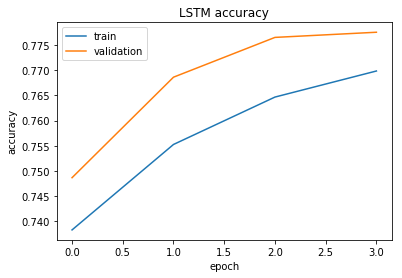

In [ ]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("LSTM-acc.png")

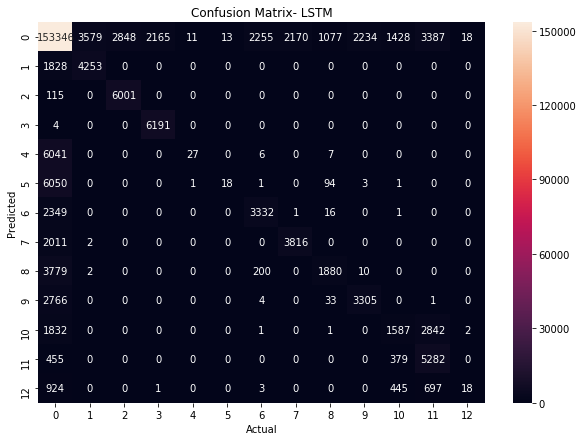

In [ ]:
import pickle
import numpy as np

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix


# getting data
with open('X_test-LSTM', 'rb') as fp:
    X_test=pickle.load(fp)

with open('y_test_LSTM', 'rb') as fp:
    y_test=pickle.load(fp)


# load model whose conf matrix you want
model=load_model('lstm.h5')

# make predictions
y_pred=model.predict(X_test)


# 12 total classes
labs=set()
labs.add(0)
labs.add(1)
labs.add(2)
labs.add(3)
labs.add(4)
labs.add(5)
labs.add(6)
labs.add(7)
labs.add(8)
labs.add(9)
labs.add(10)
labs.add(11)
labs.add(12)

preds=[]
new_test=[]

# converting one hot prediction and real label to single integer value
for i,p in enumerate(y_pred):
    preds.append(np.argmax(p))
    new_test.append(np.argmax(y_test[i]))

y_pred=preds
y_test=new_test

# making conf matrix
array=confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in list(labs)],
                  columns = [i for i in list(labs)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')

# saving matrix
plt.title("Confusion Matrix- LSTM")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("CM-lstm.png")

In [ ]:
from sklearn.metrics import classification_report

# Classification report

classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

print(classification_report(y_test, y_pred, target_names=classes))

                           precision    recall  f1-score   support

               Null class       0.84      0.88      0.86    174531
           Standing still       0.54      0.70      0.61      6081
     Sitting and relaxing       0.68      0.98      0.80      6116
               Lying down       0.74      1.00      0.85      6195
                  Walking       0.69      0.00      0.01      6081
          Climbing stairs       0.58      0.00      0.01      6168
      Waist bends forward       0.57      0.58      0.58      5699
Frontal elevation of arms       0.64      0.65      0.65      5829
Knees bending (crouching)       0.60      0.32      0.42      5871
                  Cycling       0.60      0.54      0.57      6109
                  Jogging       0.41      0.25      0.31      6265
                  Running       0.43      0.86      0.58      6116
        Jump front & back       0.47      0.01      0.02      2088

                 accuracy                           0.78    

In [ ]:
# Results: Precision, Recall, f1 score, Accuracy

from numpy import argmax
from sklearn import metrics
from sklearn.metrics import accuracy_score

print("LSTM - Accuracy:{}%".format(100*accuracy_score(y_test, y_pred)))

print("")
print("LSTM - Precision: {}%".format(100*metrics.precision_score(y_test, y_pred, average="weighted")))
print("LSTM - Recall: {}%".format(100*metrics.recall_score(y_test, y_pred, average="weighted")))
print("LSTM - f1_score: {}%".format(100*metrics.f1_score(y_test, y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

LSTM - Accuracy:77.75314724716121%

LSTM - Precision: 77.1898621162097%
LSTM - Recall: 77.75314724716121%
LSTM - f1_score: 75.19836372333245%

Confusion Matrix:
[[153346   3579   2848   2165     11     13   2255   2170   1077   2234
    1428   3387     18]
 [  1828   4253      0      0      0      0      0      0      0      0
       0      0      0]
 [   115      0   6001      0      0      0      0      0      0      0
       0      0      0]
 [     4      0      0   6191      0      0      0      0      0      0
       0      0      0]
 [  6041      0      0      0     27      0      6      0      7      0
       0      0      0]
 [  6050      0      0      0      1     18      1      0     94      3
       1      0      0]
 [  2349      0      0      0      0      0   3332      1     16      0
       1      0      0]
 [  2011      2      0      0      0      0      0   3816      0      0
       0      0      0]
 [  3779      2      0      0      0      0    200      0   1880     10

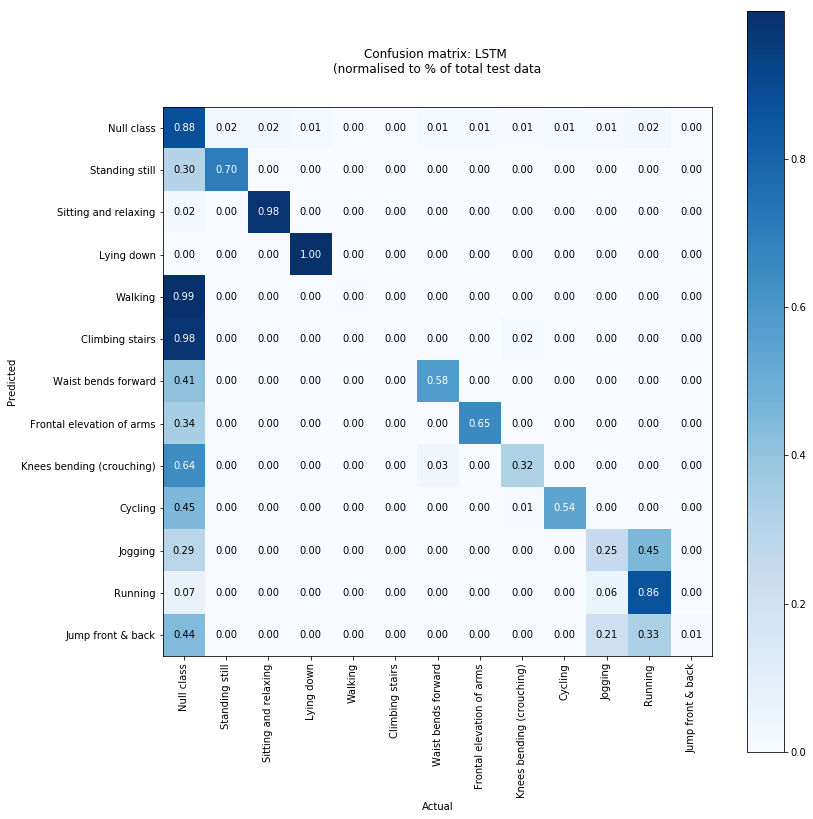

In [ ]:
# The following feature importance code is taken from this link. 
# Referenced in thesis
# https://www.oipapio.com/question-3935333

# Import libraries
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convert cm to array for multiclass cm
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
multiclass = normalised_confusion_matrix

# labels (classes)
classes = ["Null class", "Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize = (12,12))

# plot title, xaxis and yaxis, identify tickmarks, ensure tight layout
plt.title('Confusion matrix: LSTM \n(normalised to % of total test data')
plt.xlabel("Actual")
plt.ylabel("Predicted")
tick_marks = np.arange(13)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.show()

In [ ]:
# Fix accuracy

# Bar chart feature importance

from sklearn.metrics import confusion_matrix as cm
import pandas as pd

# confusion matrix
confusion_matrix=cm(y_test, y_pred)

# Create list containing labels for dataframe below
list1 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]
list2 = ["Null class","Standing still", "Sitting and relaxing","Lying down", "Walking","Climbing stairs", "Waist bends forward","Frontal elevation of arms", "Knees bending (crouching)","Cycling", "Jogging","Running", "Jump front & back"]

# convert to pandas dataframe
pd.DataFrame(confusion_matrix, list1,list2)

df = pd.DataFrame(confusion_matrix, list1,list2)
# Hard code in accuracy
df['Accuracy'] = ['89%','63%','97%','100%','0%','0%','53%','70%','38%','42%','47%','68%','0.09%']
df

,Unclassified,Standing still,Sitting and relaxing,Lying down,Walking,Climbing stairs,Waist bends forward,Frontal elevation of arms,Knees bending (crouching),Cycling,Jogging,Running,Jump front & back,Accuracy
Unclassified,154569,2516,2845,2159,0,45,1877,2890,1485,1588,2240,1905,209,91%
Standing still,2191,3769,0,0,0,0,0,0,0,0,0,0,0,89%
Sitting and relaxing,165,0,6026,0,0,0,0,0,0,0,0,0,0,99%
Lying down,0,0,0,6105,0,0,0,0,0,0,0,0,0,99%
Walking,6148,0,0,0,0,0,1,0,5,0,0,0,0,52%
Climbing stairs,5954,0,0,0,0,30,18,0,169,1,2,0,0,14%
Waist bends forward,2597,3,0,0,0,0,3009,2,95,0,0,0,0,69%
Frontal elevation of arms,1760,2,0,0,0,0,0,4143,0,0,0,0,0,80%
Knees bending (crouching),3507,2,0,0,0,0,192,0,2250,8,0,0,0,39%
Cycling,3563,0,0,0,0,0,0,0,17,2620,0,0,0,45%


In [ ]:
# The following feature importance code is taken from this link. 
# https://www.oipapio.com/question-3935333

# import libraries
from xgboost import plot_importance,XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# import libraries
import numpy as np 
from xgboost import XGBClassifier 

# Set number of estimators
xgb = XGBClassifier(n_estimators=100) 

# feature importance train test split
X_train,X_test,y_train,y_test=model_selection.train_test_split(features,labels,test_size=0.2)

# fit the model, set evaluation set and early stopping rounds
xgb = xgb.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)])

[0]	validation_0-merror:0.253651
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.253877
[2]	validation_0-merror:0.252606
[3]	validation_0-merror:0.252253
[4]	validation_0-merror:0.252228
[5]	validation_0-merror:0.251163
[6]	validation_0-merror:0.251056
[7]	validation_0-merror:0.250842
[8]	validation_0-merror:0.250739
[9]	validation_0-merror:0.250423
[10]	validation_0-merror:0.250205
[11]	validation_0-merror:0.249876
[12]	validation_0-merror:0.247733
[13]	validation_0-merror:0.244295
[14]	validation_0-merror:0.243957
[15]	validation_0-merror:0.243756
[16]	validation_0-merror:0.24346
[17]	validation_0-merror:0.24274
[18]	validation_0-merror:0.240762
[19]	validation_0-merror:0.240207
[20]	validation_0-merror:0.239199
[21]	validation_0-merror:0.239022
[22]	validation_0-merror:0.238743
[23]	validation_0-merror:0.2382
[24]	validation_0-merror:0.23574
[25]	validation_0-merror:0.235374
[26]	validation_0-merror:0.234815
[27]	validation_0-merror:0.2341

    feature  importance
3       f8         762
4      f18         742
5      f15         670
1      f17         598
10      f2         591
8      f19         538
9      f11         512
0       f0         479
2      f14         467
7       f7         456
6      f10         447
11      f9         376
13     f16         358
15     f22         329
12     f20         264
17      f6         258
19     f13         233
20     f12         205
14      f1         161
18     f21         161
16      f5         142
21      f4          91
22      f3          49


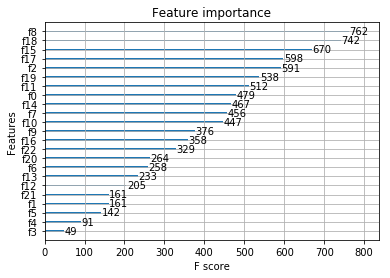

In [ ]:
# import library
import pandas as pd

# fit model
xgb_model=xgb.fit(X_train,y_train)

# convert to pandas dataframe. assign 'feature' and 'importance columns'
xgb_fea_imp=pd.DataFrame(list(xgb_model.get_booster().get_fscore().items()),
                                           
columns=['feature','importance']).sort_values('importance', ascending=False)

# print feature importance for each attribute
print('',xgb_fea_imp)

# plot importance
from xgboost import plot_importance
plot_importance(xgb_model, )